# Modeling Goals
- The aim of the competition is a plain `accuracy_score` for unlabeled data.
- From a financial perspective, the allocation of maintenance resources is vital, therefore correctly labeling the pumps which are *functional needs repair* and *non functional* can be considered the most important.

**NOTE:** *This notebook is a continuation of the `1_processing` notebook from the same directory of this repo.*

In [1]:
from support_functions import *

pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use(['ggplot', 'seaborn-talk'])

np.random.seed(RANDOM_STATE)

C:\Users\claud\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### GRID_SEARCH
**The variable below, `RUN_GRIDSEARCH` is used in this notebook as a decision to run the sklearn `GridSearchCV` with given parameters. A model param/metrics dataframe will then be dumped into the directory to replace the current df.**

**This process is computationally expensive and takes a very long time. With `RUN_GRIDSEARCH` set to False, a GridSearch will not be run, but rather the found optimizations will be fitted and shown graphically.**

In [2]:
RUN_GRIDSEARCH = False

## Reload Data
Reload from processing notebook.

In [3]:
os.listdir('processed_data/')

['.ipynb_checkpoints',
 'cat_feature_names.jobjib',
 'num_feature_names.jobjib',
 'unlabeled_y_df.csv',
 'X_test_df.csv',
 'X_train_df.csv',
 'y_test_enc.csv',
 'y_train_enc.csv']

In [4]:
label_enc = load('dumps/label_enc.jobjib')
LABEL_NAMES = label_enc.classes_
LABEL_NAMES

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [5]:
PIPELINE = load('dumps/preprocessing.jobjib')
PIPELINE

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 ['amount_tsh', 'gps_height', 'longitude',
                                  'latitude', 'num_private', 'population',
                                  'years_old', 'tsh_exists', 'installed_by_DWE',
                                  'basin_Ruvuma / Southern Coast',
                                  'subvillage_Majengo', 'subvillage_Shuleni',
                                  'subvillage_Madukani', 'su...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encod

In [6]:
# For comclusion and recommendations.
X_original = pd.read_csv('train_values.csv')
y_original = pd.read_csv('train_labels.csv')['status_group']

# For modeling.
X_train = pd.read_csv('processed_data/X_train_df.csv', index_col=0)
X_test = pd.read_csv('processed_data/X_test_df.csv', index_col=0)
y_train = pd.read_csv('processed_data/y_train_enc.csv', 
                      index_col=0)['status_group']
y_test = pd.read_csv('processed_data/y_test_enc.csv', 
                     index_col=0)['status_group']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((44550, 137), (14850, 137), (44550,), (14850,))

In [7]:
REAL_TEST = pd.read_csv('processed_data/unlabeled_y_df.csv', index_col=0)
REAL_TEST.set_index('id', drop=True, inplace=True)
print(REAL_TEST.shape)
REAL_TEST.head()

(14850, 137)


amount_tsh  gps_height  longitude  latitude  num_private  population  \
id                                                                            
50785   -0.131809    1.917381   0.186597  0.556538    -0.052648    0.296047   
51630   -0.131809    1.301208   0.394140  0.811457    -0.052648    0.252012   
17168   -0.131809    1.298322   0.107139  0.235665    -0.052648    0.671394   
45559   -0.131809   -0.577616   0.607066 -1.263768    -0.052648    0.147166   
49871    0.087249    0.855312   0.143342 -1.784060    -0.052648   -0.251248   

       years_old  tsh_exists  installed_by_DWE  basin_Ruvuma / Southern Coast  \
id                                                                              
50785  -0.439584   -0.651262         -0.644278                      -0.284459   
51630   0.343914   -0.651262          1.552125                      -0.284459   
17168  -0.309001   -0.651262         -0.644278                      -0.284459   
45559   1.192704   -0.651262         -0.644278                       3.515440   
49871   0.343914    1.535481         -0.644278                       3.515440   

       subvillage_Majengo  subvillage_Shuleni  subvillage_Madukani  \
id                                                                   
50785           -0.093367           -0.093976            -0.091763   
51630           -0.093367           -0.093976            -0.091763   
17168           -0.093367           -0.093976            -0.091763   
45559           -0.093367           -0.093976            -0.091763   
49871           -0.093367           -0.093976            -0.091763   

       subvillage_Mtakuja  subvillage_Kati  region_Iringa  region_Arusha  \
id                                                                         
50785           -0.066646        -0.081784      -0.312521      -0.245016   
51630           -0.066646        -0.081784      -0.312521       4.081366   
17168           -0.066646        -0.081784      -0.312521      -0.245016   
45559           -0.066646        -0.081784      -0.312521      -0.245016   
49871           -0.066646        -0.081784      -0.312521      -0.245016   

       region_Tabora  region_Tanga  region_code_10  region_code_15  \
id                                                                   
50785      -0.184202     -0.213146       -0.216121        -0.17772   
51630      -0.184202     -0.213146       -0.216121        -0.17772   
17168      -0.184202     -0.213146       -0.216121        -0.17772   
45559      -0.184202     -0.213146       -0.216121        -0.17772   
49871      -0.184202     -0.213146        4.627035        -0.17772   

       district_code_4  district_code_3  lga_Bariadi  lga_Siha  \
id                                                               
50785        -0.419918         2.223324     -0.14179 -0.085459   
51630        -0.419918        -0.449777     -0.14179 -0.085459   
17168        -0.419918        -0.449777     -0.14179 -0.085459   
45559        -0.419918        -0.449777     -0.14179 -0.085459   
49871        -0.419918         2.223324     -0.14179 -0.085459   

       lga_Kigoma Rural  lga_Bagamoyo  lga_Pangani  lga_Babati  \
id                                                               
50785         -0.118118     -0.131299     -0.07421   -0.092259   
51630         -0.118118     -0.131299     -0.07421   -0.092259   
17168         -0.118118     -0.131299     -0.07421   -0.092259   
45559         -0.118118     -0.131299     -0.07421   -0.092259   
49871         -0.118118     -0.131299     -0.07421   -0.092259   

       lga_Lindi Rural  lga_Kasulu  lga_Bunda  funder_Government Of Tanzania  \
id                                                                             
50785         -0.08024   -0.133841  -0.083709                      -0.426039   
51630         -0.08024   -0.133841  -0.083709                       2.347201   
17168         -0.08024   -0.133841  -0.083709                      -0.426039   
45559         -0.08024   -0.133841  -0.08370

# Modeling
In this notebook, we will be using a dummy-classifier and three predictive models.
- Random Forest Classifier
- LinearSVC
- XGBoost Classifier

## Baseline - Dummy Classifier

In [8]:
# Set up baseline dummy-classifier which predicts 
# randomly based on the class distribution.
dummy_clf = DummyClassifier(random_state=RANDOM_STATE,
                            strategy='stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=51, strategy='stratified')

********************************************************************************
*                    Dummy Classifier Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.54      0.55      0.55      8065
functional needs repair       0.07      0.07      0.07      1079
         non functional       0.39      0.39      0.39      5706

               accuracy                           0.45     14850
              macro avg       0.34      0.34      0.34     14850
           weighted avg       0.45      0.45      0.45     14850



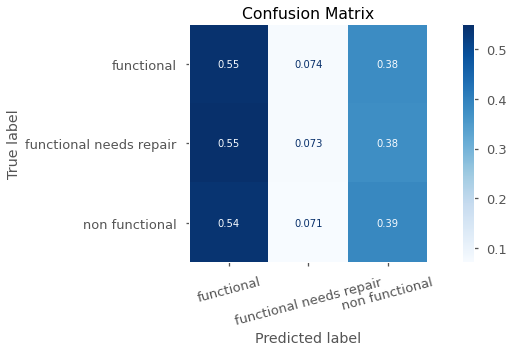

In [9]:
show_metrics(dummy_clf, X_test, y_test, 
             label='Dummy Classifier',
             target_names=LABEL_NAMES)

## Random Forest Classifier

### Vanilla Model

Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-08 15:51:35.822773             0.00000
1   Stop 2020-10-08 15:51:47.368763            11.54599

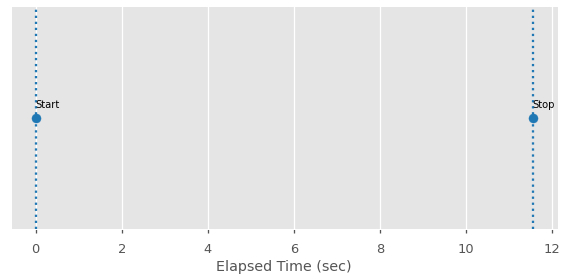

In [10]:
watch = Stopwatch()

# Starting with no parameter-tuning.
forest = RandomForestClassifier(random_state=RANDOM_STATE)
forest.fit(X_train, y_train)

watch.stop()
watch.display_laps()

********************************************************************************
*            Vanilla Random Forest Classifier Classification Report            *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.85      8065
functional needs repair       0.54      0.36      0.43      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.73      0.68      0.70     14850
           weighted avg       0.80      0.81      0.80     14850



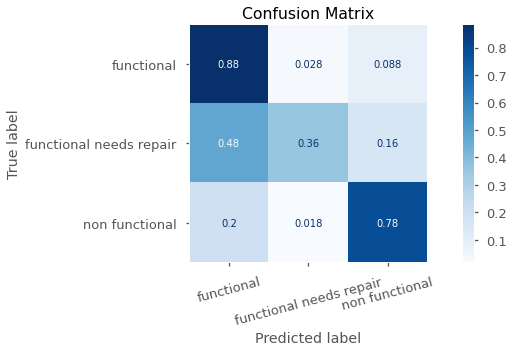

In [11]:
show_metrics(forest, X_test, y_test, 
             label='Vanilla Random Forest Classifier',
             target_names=LABEL_NAMES)

Having a vanilla Random Forest score `0.81` accuracy is pretty impressive. I feel that this might be a great model-type for this problem because of the number of categorical features and the robust-quality of a Forest. 

In [12]:
# Set up feature-importance df to plot.
feat_imp_dct = dict(
    feature = X_train.columns,
    importance = forest.feature_importances_
)
feat_imp = pd.DataFrame(feat_imp_dct)

feat_imp.sort_values('importance', ascending=False, inplace=True)
feat_imp.head(10)

feature  importance
3                       latitude    0.140303
2                      longitude    0.139093
1                     gps_height    0.068136
109                 quantity_dry    0.065532
6                      years_old    0.053381
5                     population    0.047908
110              quantity_enough    0.027152
75   extraction_type_group_other    0.021286
130        waterpoint_type_other    0.021264
0                     amount_tsh    0.020447

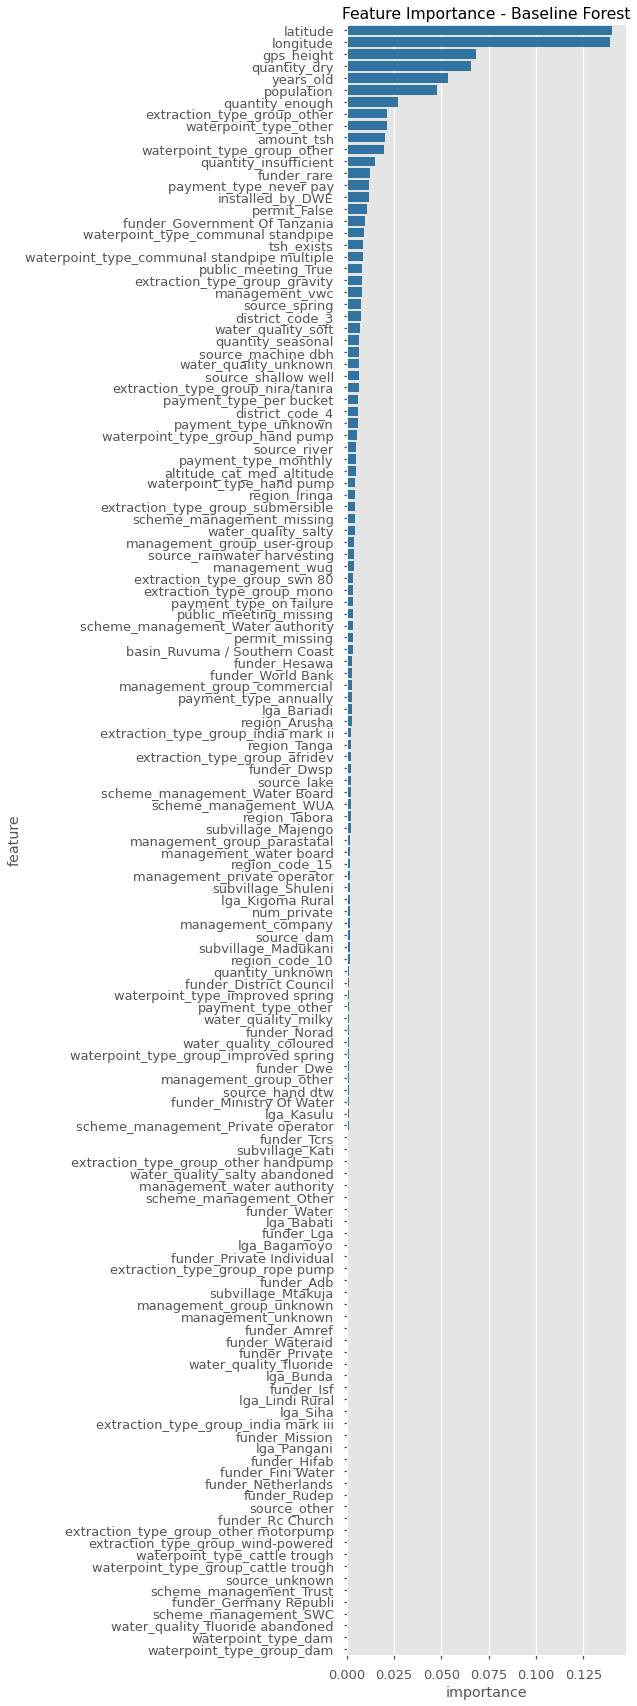

In [13]:
# Plot feature importances from vanilla model.
fig, ax = plt.subplots(figsize=(5,30))
sns.barplot(x='importance', y='feature', data=feat_imp, orient='h',
            color=COLOR, ax=ax)
ax.set(title='Feature Importance - Baseline Forest');

Interestingly, some of the top features are *locational* (`longitude` / `latitude` / `gps_height`).

### Forest GridSearch
For each model type, we will try to tune some parameters to optimize for different metrics.

In [14]:
FOREST_FNAME = 'forest_df.jobjib'

********************************************************************************
*                      RFC-accuracy Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.79      0.92      0.85      8065
functional needs repair       0.67      0.25      0.37      1079
         non functional       0.86      0.75      0.80      5706

               accuracy                           0.81     14850
              macro avg       0.77      0.64      0.67     14850
           weighted avg       0.81      0.81      0.80     14850



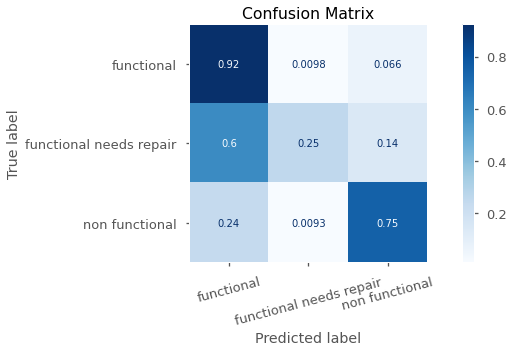

********************************************************************************
*                      RFC-f1_macro Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.85      8065
functional needs repair       0.53      0.35      0.42      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.73      0.67      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



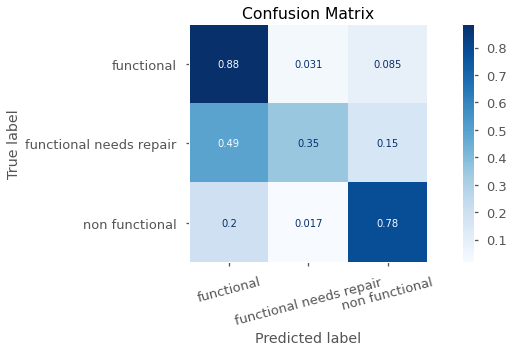

********************************************************************************
*                  RFC-precision_macro Classification Report                   *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.76      0.94      0.84      8065
functional needs repair       0.71      0.18      0.29      1079
         non functional       0.87      0.70      0.78      5706

               accuracy                           0.79     14850
              macro avg       0.78      0.61      0.63     14850
           weighted avg       0.80      0.79      0.78     14850



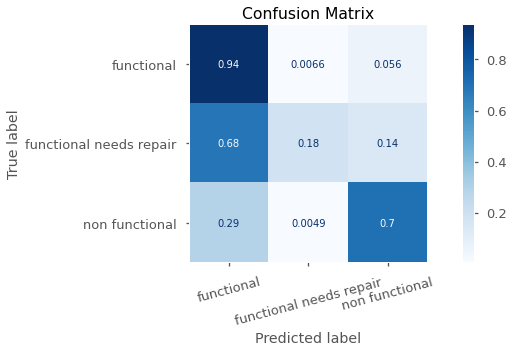

********************************************************************************
*                    RFC-recall_macro Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.81      0.88      0.84      8065
functional needs repair       0.53      0.35      0.42      1079
         non functional       0.84      0.78      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.72      0.67      0.69     14850
           weighted avg       0.80      0.81      0.80     14850



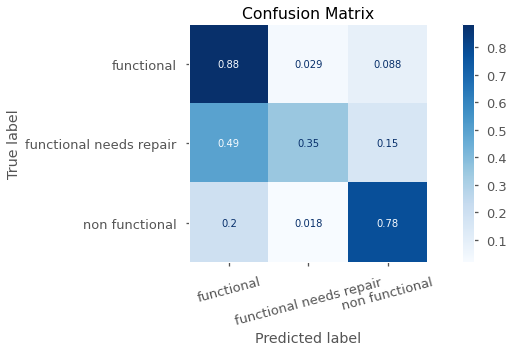

Label                  Timestamp  Elapsed Time (sec)
0                Start 2020-10-08 15:51:52.178368            0.000000
1         RFC-accuracy 2020-10-08 15:52:06.279732           14.101364
2         RFC-f1_macro 2020-10-08 15:52:21.969201           29.790833
3  RFC-precision_macro 2020-10-08 15:52:32.056613           39.878245
4     RFC-recall_macro 2020-10-08 15:52:45.356148           53.177780

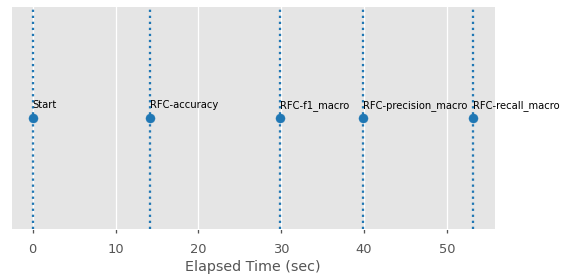

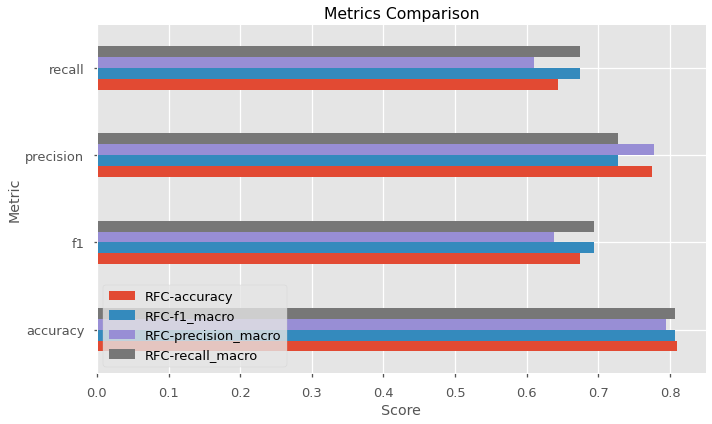

model_label                                        best_params  \
0         RFC-accuracy  {'bootstrap': False, 'criterion': 'gini', 'min...   
1         RFC-f1_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
2  RFC-precision_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
3     RFC-recall_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   

   accuracy        f1  precision    recall  
0  0.809226  0.674151   0.774674  0.643333  
1  0.807003  0.693925   0.727262  0.674195  
2  0.793939  0.638310   0.778300  0.610401  
3  0.807003  0.693925   0.727262  0.674195

In [15]:
# SEE NOTE ON `RUN_GRIDSEARCH`.
if RUN_GRIDSEARCH:
    forest_params = {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [1, 3, 5],
        'bootstrap': [True, False]
    }
    
    forest_df = gridsearch_model(RandomForestClassifier,
                                 'RFC',
                                 forest_params,
                                 X_train, X_test, y_train, y_test, 
                                 target_names=LABEL_NAMES,
                                 scoring_metrics=['accuracy', 'f1', 
                                                  'precision', 'recall'],
                                 multiclass_default_average='macro')
    
    dump(forest_df, f'models/{FOREST_FNAME}')
    
# Else, load in data.
elif FOREST_FNAME in os.listdir('models/'):
    forest_df = load(f'models/{FOREST_FNAME}')
    show_metrics_for_df(forest_df,
                        RandomForestClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(forest_df)
forest_df

The model optimized for accuracy is very good with a 0.809 `accuracy`, however it leaves some to be desired with its low `recall_macro`.
> Recall with a **macro-weight** is a harsher metric than "weighted" because it finds a balance between the categories equally, rather than making it more important to correctly identify the more-common categories.

## K-Nearest Neighbors (KNN)

### Vanilla Model

Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-08 15:52:45.649421            0.000000
1   Stop 2020-10-08 15:52:49.929923            4.280502

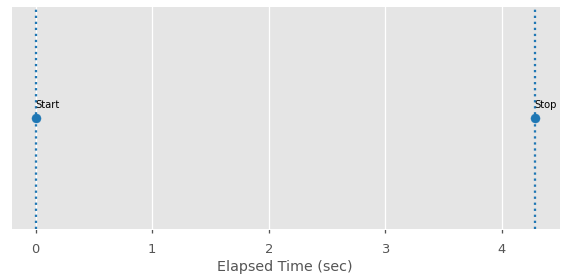

In [16]:
watch = Stopwatch()

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

watch.stop()
watch.display_laps()

********************************************************************************
*                     KNN Classifier Classification Report                     *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.86      0.81      8065
functional needs repair       0.48      0.31      0.38      1079
         non functional       0.80      0.72      0.75      5706

               accuracy                           0.77     14850
              macro avg       0.68      0.63      0.65     14850
           weighted avg       0.76      0.77      0.76     14850



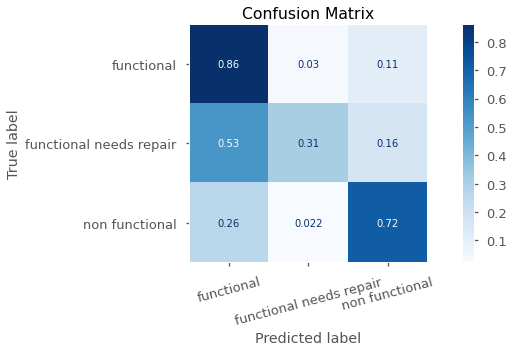

In [17]:
show_metrics(knn, X_test, y_test, 
             label='KNN Classifier',
             target_names=LABEL_NAMES)

### KNN GridSearch

In [18]:
KNN_FNAME = 'knn_df.jobjib'

********************************************************************************
*                      KNN-accuracy Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.76     14850
              macro avg       0.67      0.63      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



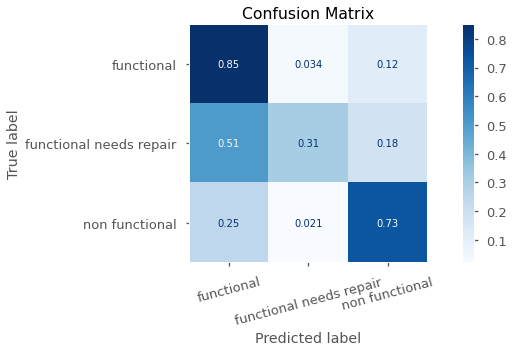

********************************************************************************
*                      KNN-f1_macro Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.76     14850
              macro avg       0.67      0.63      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



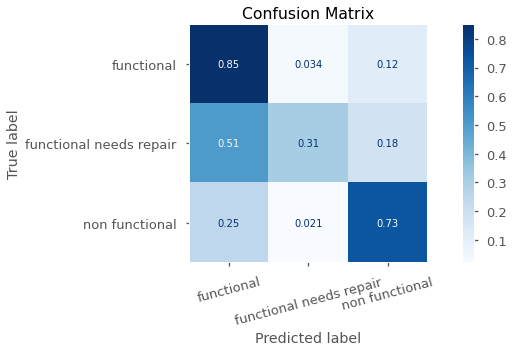

********************************************************************************
*                  KNN-precision_macro Classification Report                   *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.75      0.86      0.81      8065
functional needs repair       0.55      0.28      0.37      1079
         non functional       0.78      0.69      0.73      5706

               accuracy                           0.75     14850
              macro avg       0.69      0.61      0.64     14850
           weighted avg       0.75      0.75      0.75     14850



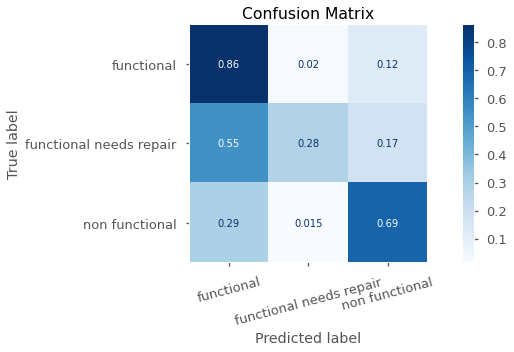

********************************************************************************
*                    KNN-recall_macro Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.78      0.85      0.81      8065
functional needs repair       0.46      0.31      0.37      1079
         non functional       0.79      0.73      0.76      5706

               accuracy                           0.76     14850
              macro avg       0.67      0.63      0.65     14850
           weighted avg       0.76      0.76      0.76     14850



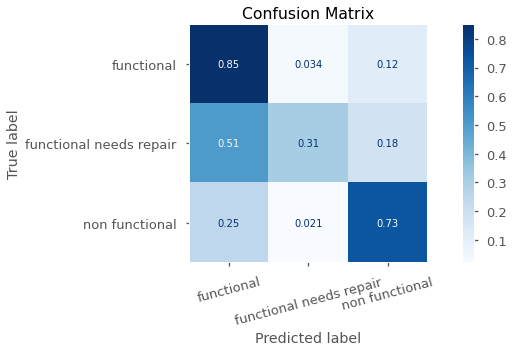

Label                  Timestamp  Elapsed Time (sec)
0                Start 2020-10-08 15:54:39.688917            0.000000
1         KNN-accuracy 2020-10-08 15:56:23.017460          103.328543
2         KNN-f1_macro 2020-10-08 15:58:25.510907          225.821990
3  KNN-precision_macro 2020-10-08 16:00:36.235269          356.546352
4     KNN-recall_macro 2020-10-08 16:02:20.806320          461.117403

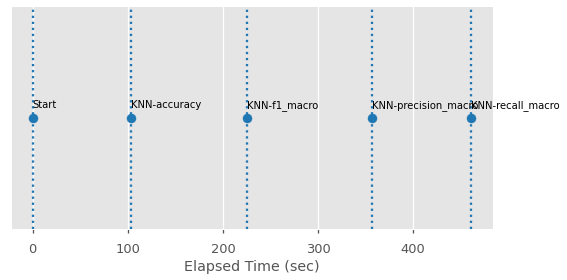

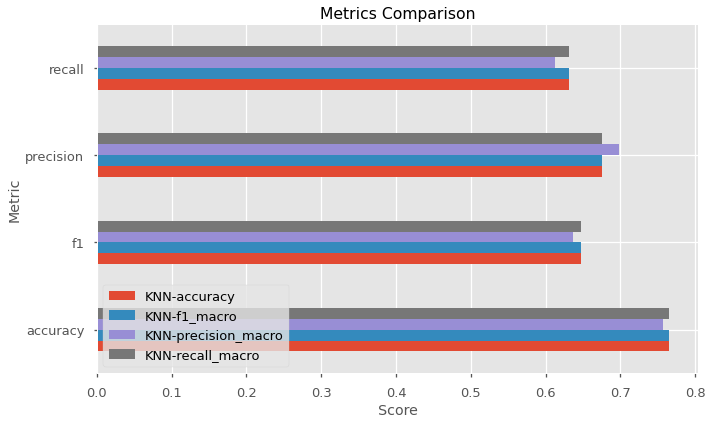

model_label         best_params  accuracy        f1  precision  \
0         KNN-accuracy  {'n_neighbors': 3}  0.765589  0.647659   0.675512   
1         KNN-f1_macro  {'n_neighbors': 3}  0.765589  0.647659   0.675512   
2  KNN-precision_macro  {'n_neighbors': 9}  0.756566  0.637257   0.697740   
3     KNN-recall_macro  {'n_neighbors': 3}  0.765589  0.647659   0.675512   

     recall  
0  0.631222  
1  0.631222  
2  0.612245  
3  0.631222

In [19]:
if RUN_GRIDSEARCH:
    knn_params = {
        'n_neighbors': [3, 5, 7, 9]
    }

    knn_df = gridsearch_model(KNeighborsClassifier,
                              'KNN',
                              knn_params,
                              X_train, X_test, y_train, y_test, 
                              target_names=LABEL_NAMES,
                              scoring_metrics=['accuracy', 'f1', 
                                               'precision', 'recall'],
                              multiclass_default_average='macro')
    
    dump(knn_df, f'models/{KNN_FNAME}')
    
elif KNN_FNAME in os.listdir('models/'):
    knn_df = load(f'models/{KNN_FNAME}')
    show_metrics_for_df(knn_df,
                        KNeighborsClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(knn_df)
knn_df

These models aren't showing as much accuracy as the Random Forests, nor do they seem to be better at finding the minority class `functional needs repair`.

## XGBoost

### Vanilla Model

Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-08 16:02:21.078402             0.00000
1   Stop 2020-10-08 16:02:53.077032            31.99863

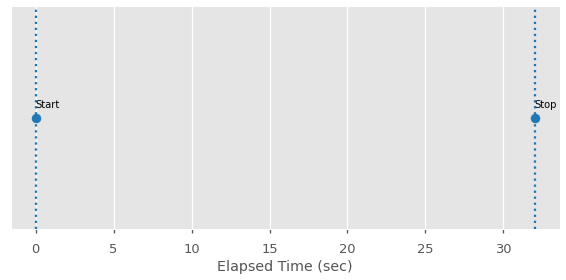

In [20]:
watch = Stopwatch()

xgb = XGBClassifier(random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)

watch.stop()
watch.display_laps()

********************************************************************************
*                 Vanilla XGBClassifier Classification Report                  *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.72      0.93      0.81      8065
functional needs repair       0.61      0.12      0.21      1079
         non functional       0.84      0.61      0.71      5706

               accuracy                           0.75     14850
              macro avg       0.72      0.55      0.57     14850
           weighted avg       0.76      0.75      0.73     14850



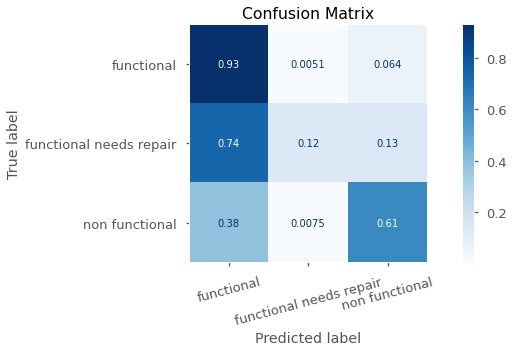

In [21]:
show_metrics(xgb, X_test, y_test, 
             label='Vanilla XGBClassifier',
             target_names=LABEL_NAMES)

### XGB GridSearch

In [22]:
XGB_FNAME = 'xgb_df.jobjib'

********************************************************************************
*                      xgb-accuracy Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



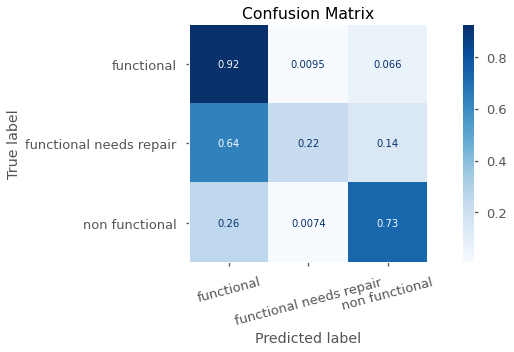

********************************************************************************
*                      xgb-f1_macro Classification Report                      *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



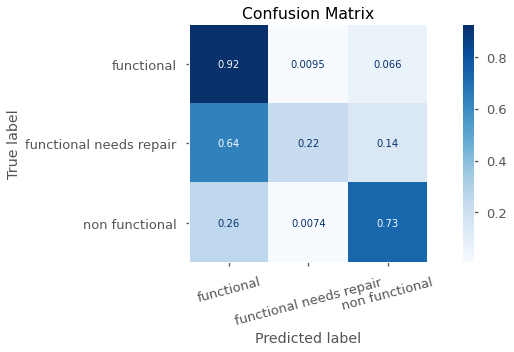

********************************************************************************
*                  xgb-precision_macro Classification Report                   *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



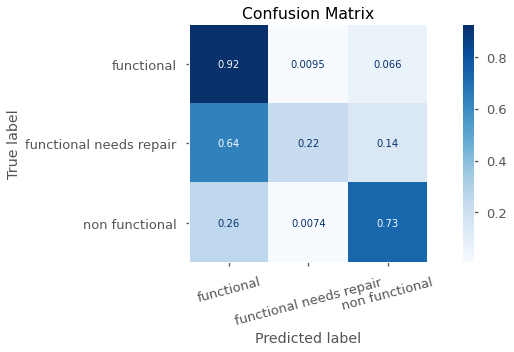

********************************************************************************
*                    xgb-recall_macro Classification Report                    *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.77      0.92      0.84      8065
functional needs repair       0.67      0.22      0.34      1079
         non functional       0.86      0.73      0.79      5706

               accuracy                           0.80     14850
              macro avg       0.77      0.63      0.66     14850
           weighted avg       0.80      0.80      0.79     14850



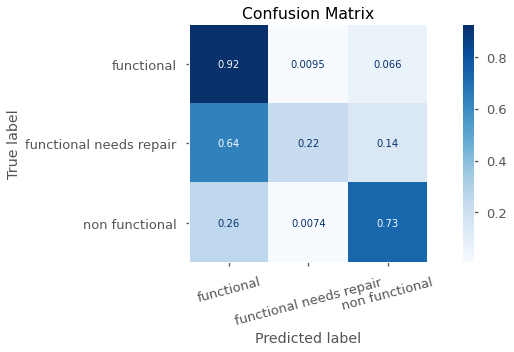

Label                  Timestamp  Elapsed Time (sec)
0                Start 2020-10-08 16:02:53.694939            0.000000
1         xgb-accuracy 2020-10-08 16:04:20.612430           86.917491
2         xgb-f1_macro 2020-10-08 16:05:47.730022          174.035083
3  xgb-precision_macro 2020-10-08 16:07:14.443631          260.748692
4     xgb-recall_macro 2020-10-08 16:08:40.120614          346.425675

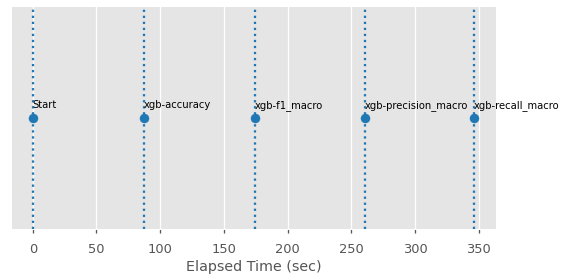

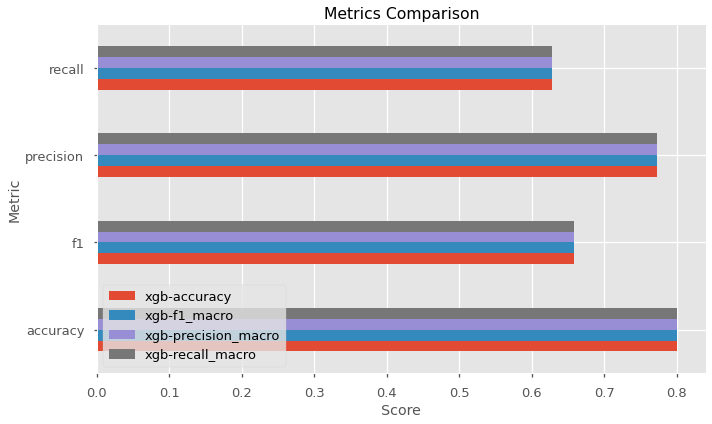

model_label                             best_params  accuracy  \
0         xgb-accuracy  {'learning_rate': 0.1, 'max_depth': 9}       0.8   
1         xgb-f1_macro  {'learning_rate': 0.1, 'max_depth': 9}       0.8   
2  xgb-precision_macro  {'learning_rate': 0.1, 'max_depth': 9}       0.8   
3     xgb-recall_macro  {'learning_rate': 0.1, 'max_depth': 9}       0.8   

         f1  precision    recall  
0  0.657927   0.772328  0.627689  
1  0.657927   0.772328  0.627689  
2  0.657927   0.772328  0.627689  
3  0.657927   0.772328  0.627689

In [23]:
if RUN_GRIDSEARCH:
    xgb_params = {
        'max_depth': [3, 5, 7]
    }

    xgb_df = gridsearch_model(XGBClassifier,
                              'XGB',
                              xgb_params,
                              X_train, X_test, y_train, y_test, 
                              target_names=LABEL_NAMES,
                              scoring_metrics=['accuracy', 'f1', 
                                               'precision', 'recall'],
                              multiclass_default_average='macro')
    
    dump(knn_df, f'models/{XGB_FNAME}')
    
elif XGB_FNAME in os.listdir('models/'):
    xgb_df = load(f'models/{XGB_FNAME}')
    show_metrics_for_df(xgb_df,
                        XGBClassifier,
                        X_train,
                        X_test,
                        y_train,
                        y_test,
                        target_names=LABEL_NAMES)
    
plot_comparisons(xgb_df)
xgb_df

The XGB models are tending to prioritize over-guessing the most common target variable - `functional`.

# Class Imbalance: SMOTE-NC
There are certainly some decent results, but a more balanced training set might help the models predict the minority classes.

- **SMOTENC** is a version of *SMOTE* which can handle one-hot-encoded columns by indicating which columns to treat as categorical.
- It will then create new data points (synthetically) to train on with hopes to get better modeling results.

In [24]:
# Loading columns from processing notebook.
categorical_columns = load('processed_data/cat_feature_names.jobjib')
numerical_columns = load('processed_data/num_feature_names.jobjib')

print('Num:', len(numerical_columns),' Cat:', len(categorical_columns))

Num: 57  Cat: 80


In [25]:
# Get column indexes which are categorical.
cat_col_idxs = np.array([list(X_train.columns).index(c) 
                         for c in categorical_columns])

# Use SMOTENC for continuous and categorical columns.
smote = SMOTENC(random_state=RANDOM_STATE, 
                categorical_features=cat_col_idxs)
smote

SMOTENC(categorical_features=array([ 57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136]),
        random_state=51)

In [26]:
# Synthesize training data to redistribute target classes.
string1 = 'Original Class Distribution'
print(headerize(string1))
print(y_train.value_counts(normalize=True))

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

string2 = 'Resampled Distribution'
print(headerize(string2))
print(pd.Series(y_train_res).value_counts(normalize=True))

********************************************************************************
*                         Original Class Distribution                          *
********************************************************************************
0    0.543075
2    0.384242
1    0.072682
Name: status_group, dtype: float64
********************************************************************************
*                            Resampled Distribution                            *
********************************************************************************
2    0.333333
1    0.333333
0    0.333333
Name: status_group, dtype: float64


## Fit re-sampled data.

********************************************************************************
*                                     rfc                                      *
********************************************************************************
********************************************************************************
*                                     knn                                      *
********************************************************************************
********************************************************************************
*                                     xgb                                      *
********************************************************************************


Label                  Timestamp  Elapsed Time (sec)
0  Start 2020-10-08 16:11:10.265094            0.000000
1    rfc 2020-10-08 16:11:27.709441           17.444347
2    knn 2020-10-08 16:11:36.608676           26.343582
3    xgb 2020-10-08 16:13:58.889311          168.624217

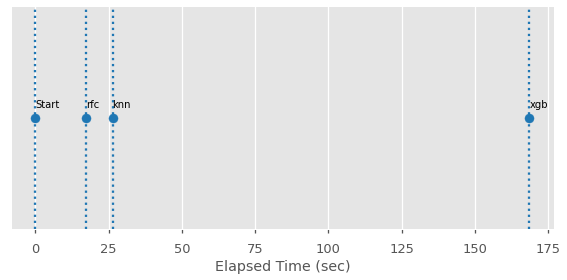

[(RandomForestClassifier(bootstrap=False, min_samples_leaf=3), 'rfc'),
 (KNeighborsClassifier(n_neighbors=3), 'knn'),
 (XGBClassifier(max_depth=9, objective='multi:softprob'), 'xgb')]

In [27]:
# Get best accuracy model-params for each model type.
best_params_df_lst = [
    (RandomForestClassifier, forest_df, 'rfc'),
    (KNeighborsClassifier, knn_df, 'knn'),
    (XGBClassifier, xgb_df, 'xgb')
]

# Instantiate each model with its best accuracy params.
watch = Stopwatch()

models = []
for model, df, name in best_params_df_lst:
    params = df.iloc[0]['best_params']  # accuracy
    
    # Fit with synthesized data.
    m = model(**params).fit(X_train_res, y_train_res)
    models.append((m, name))
    
    print(headerize(name))
    watch.lap(label=name)
    
watch.stop()
watch.display_laps(show_stop=False)

models

********************************************************************************
*                          rfc Classification Report                           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.83      0.81      0.82      8065
functional needs repair       0.34      0.58      0.43      1079
         non functional       0.84      0.76      0.80      5706

               accuracy                           0.78     14850
              macro avg       0.67      0.72      0.68     14850
           weighted avg       0.80      0.78      0.78     14850



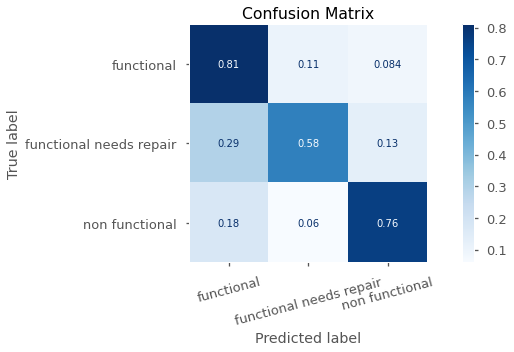

********************************************************************************
*                          knn Classification Report                           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.80      0.78      0.79      8065
functional needs repair       0.33      0.46      0.38      1079
         non functional       0.77      0.75      0.76      5706

               accuracy                           0.74     14850
              macro avg       0.63      0.66      0.64     14850
           weighted avg       0.75      0.74      0.75     14850



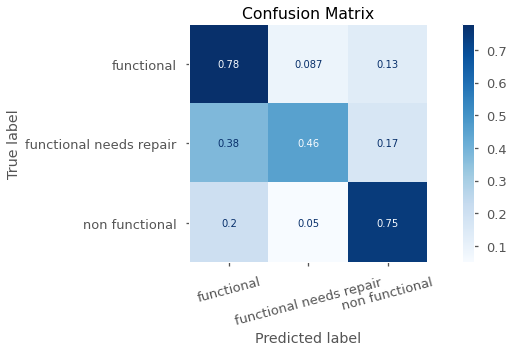

********************************************************************************
*                          xgb Classification Report                           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.82      0.77      0.80      8065
functional needs repair       0.29      0.62      0.39      1079
         non functional       0.84      0.73      0.78      5706

               accuracy                           0.74     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.74      0.76     14850



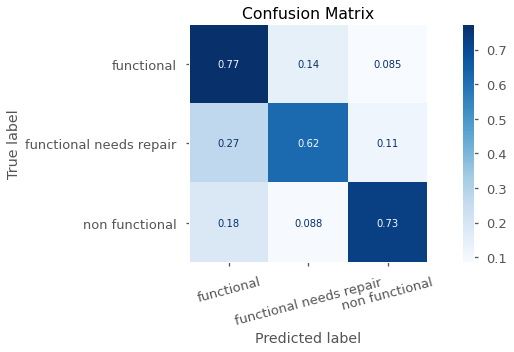

In [28]:
# Evaluate performance.
for model, name in models:
    show_metrics(model, X_test, y_test, 
                 label=name,
                 target_names=LABEL_NAMES)

In some ways, these models are performing much better than with the unbalanced training data.
- They are predicting the minority class *much* more accurately.
- The f1-macro score has increased.

However, their accuracy has diminished due in large part to the number of the majority class (*functional*) which are being mislabeled.

***

Finally, I'm going to try an ensemble with these three classifiers with the SMOTE data to improve the final predictions.

# Creating an Ensemble

In [29]:
# Select what metric to use for the optimized models.
model_optimization_dct = {
    'accuracy': 0,
    'f1_macro': 1,
    'precision_macro': 2,
    'recall_macro': 3
}

# Selecting metric.
OPTIMIZATION_SELECTION = model_optimization_dct['accuracy']
OPTIMIZATION_SELECTION

0

In [30]:
# Our `models` list has models which have already been fit.
unfit_models = []
for clf, df, name in best_params_df_lst:
    params = df.iloc[OPTIMIZATION_SELECTION]['best_params']
    unfit_models.append((name, clf(**params)))
unfit_models

[('rfc', RandomForestClassifier(bootstrap=False, min_samples_leaf=3)),
 ('knn', KNeighborsClassifier(n_neighbors=3)),
 ('xgb', XGBClassifier(max_depth=9))]

## Train Separately on Resampled Data and Original Data

********************************************************************************
*                                   Original                                   *
********************************************************************************
********************************************************************************
*           Stacking Classifier: Original Data Classification Report           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      8065
functional needs repair       0.64      0.30      0.40      1079
         non functional       0.85      0.77      0.81      5706

               accuracy                           0.81     14850
              macro avg       0.76      0.66      0.69     14850
           weighted avg       0.81      0.81      0.80     14850



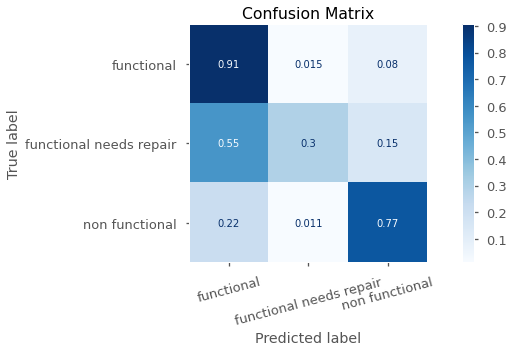

********************************************************************************
*                                  Resampled                                   *
********************************************************************************
********************************************************************************
*          Stacking Classifier: Resampled Data Classification Report           *
********************************************************************************
                         precision    recall  f1-score   support

             functional       0.83      0.81      0.82      8065
functional needs repair       0.37      0.49      0.42      1079
         non functional       0.82      0.79      0.80      5706

               accuracy                           0.78     14850
              macro avg       0.67      0.70      0.68     14850
           weighted avg       0.79      0.78      0.78     14850



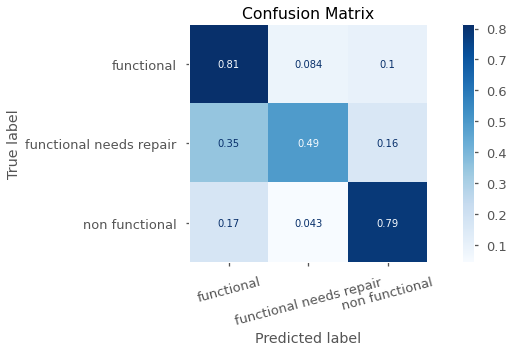

Label                  Timestamp  Elapsed Time (min)
0      Start 2020-10-08 16:16:21.152527                0.00
1   Original 2020-10-08 16:29:06.438429               12.75
2  Resampled 2020-10-08 17:11:53.141060               55.53

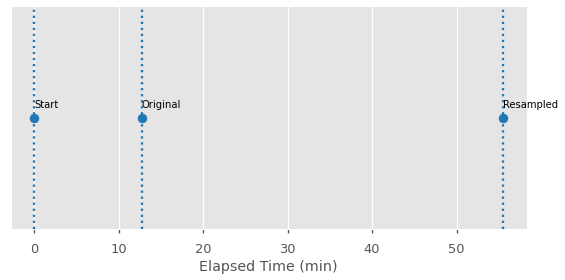

In [31]:
data = [
    (X_train, y_train, 'Original'),
    (X_train_res, y_train_res, 'Resampled')
]

clf_dct = {}

watch = Stopwatch()
for X, y, label in data:
    print(headerize(label))
    stack_clf = StackingClassifier(estimators=unfit_models)
    stack_clf.fit(X, y)

    show_metrics(stack_clf,
                 X_test, 
                 y_test, 
                 label=f'Stacking Classifier: {label} Data',
                 target_names=LABEL_NAMES)
    clf_dct[label] = stack_clf
    watch.lap(label=label)
    
watch.display_laps(minutes_elapsed=True)

In [32]:
clf_dct

{'Original': StackingClassifier(estimators=[('rfc',
                                 RandomForestClassifier(bootstrap=False,
                                                        min_samples_leaf=3)),
                                ('knn', KNeighborsClassifier(n_neighbors=3)),
                                ('xgb', XGBClassifier(max_depth=9))]),
 'Resampled': StackingClassifier(estimators=[('rfc',
                                 RandomForestClassifier(bootstrap=False,
                                                        min_samples_leaf=3)),
                                ('knn', KNeighborsClassifier(n_neighbors=3)),
                                ('xgb', XGBClassifier(max_depth=9))])}

These are two very interesting models.
***
**Original Training Data Model**
- On one hand, we have a model which has a higher overall accuracy (0.81).
- **0.9 recall** for functional water pumps, **0.77 recall** for non-functional pumps.
- The drawback is that more functional needs repair pumps are mislabeled than labeled correctly.

**Resampled Training Data Model**
- The first point to note is the 
- The accuracy is lower (**0.78**), but non functional recall is improved slightly (from 0.77 to **0.79**)
- This model would be good if you especially wanted to try and catch a water pump before it became non functional if it were cheaper to repair it.improvement in the minority class functional needs repair.

# REAL_TEST predictions

In [33]:
X_test_real = REAL_TEST.reset_index(drop=True)
X_test_real

amount_tsh  gps_height  longitude  latitude  num_private  population  \
0       -0.131809    1.917381   0.186597  0.556538    -0.052648    0.296047   
1       -0.131809    1.301208   0.394140  0.811457    -0.052648    0.252012   
2       -0.131809    1.298322   0.107139  0.235665    -0.052648    0.671394   
3       -0.131809   -0.577616   0.607066 -1.263768    -0.052648    0.147166   
4        0.087249    0.855312   0.143342 -1.784060    -0.052648   -0.251248   
...           ...         ...        ...       ...          ...         ...   
14845   -0.131809   -0.913841   0.727804 -0.300509    -0.052648   -0.335124   
14846    0.306308   -0.962904   0.514924  0.118110    -0.052648    5.829802   
14847   -0.131809    1.167006   0.102876  0.377906    -0.052648    0.042320   
14848   -0.131809    0.477238   0.208163 -1.659653    -0.052648   -0.062525   
14849   -0.131809   -0.268807   0.106713 -1.877674    -0.052648   -0.293186   

       years_old  tsh_exists  installed_by_DWE  basin_Ruvuma / Southern Coast  \
0      -0.439584   -0.651262         -0.644278                      -0.284459   
1       0.343914   -0.651262          1.552125                      -0.284459   
2      -0.309001   -0.651262         -0.644278                      -0.284459   
3       1.192704   -0.651262         -0.644278                       3.515440   
4       0.343914    1.535481         -0.644278                       3.515440   
...          ...         ...               ...                            ...   
14845   1.127413   -0.651262         -0.644278                      -0.284459   
14846   0.735664    1.535481         -0.644278                      -0.284459   
14847  -0.309001   -0.651262         -0.644278                      -0.284459   
14848  -0.243710   -0.651262          1.552125                      -0.284459   
14849  -0.178418   -0.651262         -0.644278                      -0.284459   

       subvillage_Majengo  subvillage_Shuleni  subvillage_Madukani  \
0               -0.093367           -0.093976            -0.091763   
1               -0.093367           -0.093976            -0.091763   
2               -0.093367           -0.093976            -0.091763   
3               -0.093367           -0.093976            -0.091763   
4               -0.093367           -0.093976            -0.091763   
...                   ...                 ...                  ...   
14845           -0.093367           -0.093976            -0.091763   
14846           -0.093367           -0.093976            -0.091763   
14847           -0.093367           -0.093976            -0.091763   
14848           -0.093367           -0.093976            -0.091763   
14849           -0.093367           -0.093976            -0.091763   

       subvillage_Mtakuja  subvillage_Kati  region_Iringa  region_Arusha  \
0               -0.066646        -0.081784      -0.312521      -0.245016   
1               -0.066646        -0.081784      -0.312521       4.081366   
2               -0.066646        -0.081784      -0.312521      -0.245016   
3               -0.066646        -0.081784      -0.312521      -0.245016   
4               -0.066646        -0.081784      -0.312521      -0.245016   
...                   ...              ...            ...            ...   
14845           -0.066646        -0.081784      -0.312521      -0.245016   
14846           -0.066646        -0.081784      -0.312521      -0.245016   
14847           -0.066646        -0.081784      -0.312521      -0.245016   
14848           -0.066646        -0.081784      -0.312521      -0.245016   
14849           -0.066646        -0.081784      -0.312521      -0.245016   

       region_Tabora  region_Tanga  region_code_10  region_code_15  \
0          -0.184202     -0.213146       -0.216121        -0.17772   
1          -0.184202     -0.213146       -0.216121        -0.17772   
2          -0.184202     -0.213146       -0.216121        -0.17772   
3          -0.184202     -0.213146       -0.216121 

In [34]:
y_ids = REAL_TEST.reset_index()[['id']]
y_ids

id
0      50785
1      51630
2      17168
3      45559
4      49871
...      ...
14845  39307
14846  18990
14847  28749
14848  33492
14849  68707

[14850 rows x 1 columns]

## Random Forest Predictions - Original Data

In [35]:
forest_df

model_label                                        best_params  \
0         RFC-accuracy  {'bootstrap': False, 'criterion': 'gini', 'min...   
1         RFC-f1_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
2  RFC-precision_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   
3     RFC-recall_macro  {'bootstrap': True, 'criterion': 'entropy', 'm...   

   accuracy        f1  precision    recall  
0  0.809226  0.674151   0.774674  0.643333  
1  0.807003  0.693925   0.727262  0.674195  
2  0.793939  0.638310   0.778300  0.610401  
3  0.807003  0.693925   0.727262  0.674195

In [36]:
params = forest_df.iloc[0]['best_params']
params['random_state'] = RANDOM_STATE

rfc_final = RandomForestClassifier(**params)
rfc_final.fit(X_train, y_train)
rfc_final

RandomForestClassifier(bootstrap=False, min_samples_leaf=3, random_state=51)

In [37]:
y_ids['RFC'] = rfc_final.predict(X_test_real)
y_ids

id  RFC
0      50785    2
1      51630    0
2      17168    0
3      45559    2
4      49871    0
...      ...  ...
14845  39307    2
14846  18990    0
14847  28749    0
14848  33492    0
14849  68707    2

[14850 rows x 2 columns]

## Ensemble Predictions

In [38]:
for k in clf_dct.keys():
    y_ids[k] = clf_dct[k].predict(X_test_real)
    
y_ids

id  RFC  Original  Resampled
0      50785    2         2          2
1      51630    0         0          0
2      17168    0         0          0
3      45559    2         2          2
4      49871    0         0          0
...      ...  ...       ...        ...
14845  39307    2         2          2
14846  18990    0         0          0
14847  28749    0         0          0
14848  33492    0         0          0
14849  68707    2         2          2

[14850 rows x 4 columns]

## Submissions

In [39]:
# Inverse transform the target.
y_ids_inv = y_ids.copy()

y_ids_inv['RFC'] = label_enc.inverse_transform(y_ids['RFC'])
y_ids_inv['Original'] = label_enc.inverse_transform(y_ids['Original'])
y_ids_inv['Resampled'] = label_enc.inverse_transform(y_ids['Resampled'])

y_ids_inv

id             RFC        Original       Resampled
0      50785  non functional  non functional  non functional
1      51630      functional      functional      functional
2      17168      functional      functional      functional
3      45559  non functional  non functional  non functional
4      49871      functional      functional      functional
...      ...             ...             ...             ...
14845  39307  non functional  non functional  non functional
14846  18990      functional      functional      functional
14847  28749      functional      functional      functional
14848  33492      functional      functional      functional
14849  68707  non functional  non functional  non functional

[14850 rows x 4 columns]

In [40]:
def format_for_competition(dataframe, col):
    """Return a reformatted slice of the dataframe to submit."""
    
    submission = dataframe[['id', col]].copy()
    submission.columns = ['id', 'status_group']
    return submission

In [41]:
rfc_submission = format_for_competition(y_ids_inv, 'RFC')
rfc_submission

id    status_group
0      50785  non functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]

In [42]:
original_submission = format_for_competition(y_ids_inv, 'Original')
original_submission

id    status_group
0      50785  non functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]

In [43]:
resampled_submission = format_for_competition(y_ids_inv, 'Resampled')
resampled_submission

id    status_group
0      50785  non functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]

In [44]:
rfc_submission.to_csv('competition_predictions/rfc.csv', 
                      index=False)
original_submission.to_csv('competition_predictions/original.csv', 
                           index=False)
resampled_submission.to_csv('competition_predictions/resampled.csv', 
                            index=False)

# Results
**Random Forest - Original Sampling**
<img src='rfc_results.png'>
**Ensemble - Original Sampling Method**
<img src='original_sample_results.png'>
**Ensemble - Post-SMOTE-NC Sampling**
<img src='resampled_results.png'>